In [1]:
# 행렬 분해 : R = F * B
# NaN이 포함된 R이 주어졌을 때 행렬 F, B를 추정한다. (by Stochastic Gradient Descent)
import numpy as np
import numba as nb
import matplotlib.pyplot as plt
import pandas as pd

In [9]:
# Load the dataset
df = pd.read_csv("average equal weighted.csv", index_col=0)

In [7]:
top50 = pd.read_csv("top50-Stock_LogReturn.csv", index_col="Date")
top50key = top50.keys()

df = pd.read_csv("Stock_price.csv")
df['Date'] = pd.to_datetime(df['Date'])

df = df.set_index('Date')
df_w = df.resample('W').agg('last')

df_w_top50 = df_w[top50key]

df_w_logretrun = np.log(df_w_top50 / df_w_top50.shift(1))
df_w_logretrun = df_w_logretrun.dropna(axis=0)
#df_w_logretrun.to_csv("top50-W-Stock_LogReturn.csv")


Expected :
[[0.0065 0.0055 0.0051 0.0046 0.0045 0.0043 0.0039 0.0038 0.0037 0.0036
  0.0037 0.0035 0.0035 0.0035 0.0035 0.0034 0.0034 0.0034 0.0032 0.0033
  0.0033 0.0033 0.0033 0.0033 0.0033 0.0032 0.0033 0.0032 0.0029 0.0032
  0.0032 0.0031 0.0031 0.0031 0.0031 0.0031 0.0031 0.003  0.003  0.003
  0.003  0.003  0.0029 0.003  0.0029 0.003  0.0029 0.0029 0.0029 0.0029]]
0 : error=0.0377


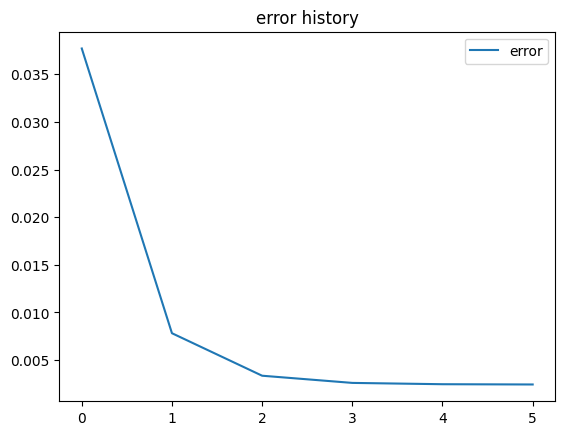


R :
[[ 0.   -0.12  0.02 ... -0.11 -0.05  0.01]
 [ 0.    0.05  0.02 ...  0.02 -0.02  0.04]
 [-0.03  0.05 -0.04 ...  0.09  0.    0.07]
 ...
 [ 0.02  0.01 -0.05 ... -0.   -0.01  0.03]
 [ 0.04 -0.02 -0.01 ... -0.01  0.03  0.03]
 [-0.   -0.    0.03 ...  0.01  0.02  0.04]]

Estimated R :
[[ 0.01 -0.01 -0.   ...  0.   -0.    0.  ]
 [ 0.02  0.   -0.   ... -0.    0.    0.  ]
 [-0.01  0.   -0.01 ...  0.    0.01 -0.01]
 ...
 [ 0.01  0.01  0.01 ...  0.   -0.    0.01]
 [ 0.02  0.    0.   ...  0.01  0.    0.01]
 [ 0.   -0.01  0.   ... -0.01 -0.    0.  ]]

F :
[[ 0.04  0.14  0.11 ... -0.17 -0.1  -0.27]
 [-0.21  0.23 -0.16 ...  0.13  0.17  0.06]
 [-0.34 -0.22  0.   ... -0.31 -0.27 -0.29]
 ...
 [ 0.21  0.95  0.49 ...  0.47  0.64  0.69]
 [ 0.21  0.1   0.94 ...  0.11  0.06  0.16]
 [ 0.71  0.49  0.45 ...  0.1   0.37  0.78]]

B :
[[-0.01 -0.    0.   ...  0.   -0.   -0.  ]
 [-0.01 -0.01  0.   ... -0.   -0.   -0.  ]
 [ 0.01  0.    0.01 ...  0.01  0.    0.01]
 ...
 [-0.    0.    0.   ... -0.01  0.    0.  ]
 

In [6]:
K = 30 # number of factors

# 주간 수익률 데이터를 읽어온다.
rtn_df = pd.read_csv('top50-W-Stock_LogReturn.csv', index_col='Date')
rtn_R = np.array(rtn_df)

N_ROW = rtn_df.shape[0] # time 개수
N_COL = rtn_R.shape[1] # item (종목) 개수

# mean centering
E = rtn_R.mean(axis=0).reshape(1, N_COL)
cent_R = rtn_R - E

# User-item matrix
N = np.NaN
R = np.array(rtn_R)

print('\nExpected :')
print(E.round(4))

@nb.jit
# SGD로 행렬 F, B를 업데이트한다.
def update_matrix(R, F, B, a, r):
    for i in range(N_ROW):
        for j in range(N_COL):
            if np.isnan(R[i, j]) != True:  # nan이 아니면
                # error 항을 계산한다.
                eij = R[i, j] - np.dot(F[i, :], B[j, :])
                
                # update F, B
                F[i, :] += a * (eij * B[j, :] - r * F[i, :])
                B[j, :] += a * (eij * F[i, :] - r * B[j, :])

@nb.jit
# NaN이 포함된 행렬의 mean_squared_error를 계산한다. 행렬 x에는 NaN이 포함돼 있다. y에는 없다.
def mse_skip_nan(x, y):
    mse = 0.0
    cnt = 0
    for i in range(x.shape[0]):
        for j in range(x.shape[1]):
            if np.isnan(x[i, j]) != True:  # nan이 아니면
                mse += (x[i, j] - y[i, j]) ** 2
                cnt += 1
    return mse / cnt

# SGD로 행렬을 F, B로 분해한다.
def factorize_matrix(matR, k, max_iter=1000, alpha=0.01, gamma=0.01, err_limit=1e-4):
    # F, B를 random 초기화한다.
    F = np.random.rand(N_ROW, k)  # factor matrix
    B = np.random.rand(N_COL, k)  # beta matrix.

    old_err = 9999   # error 초깃값
    err_hist = []    # error history
    for step in range(max_iter):
        # F, B를 업데이트한다.
        update_matrix(matR, F, B, alpha, gamma)

        # error를 계산하고 저장해 둔다.
        err = mse_skip_nan(matR, np.dot(F, B.T))
        err_hist.append(err)

        # early stopping
        if np.abs(old_err - err) < err_limit:
            break
        
        old_err = err

        if step % 10 == 0:
            print('{} : error={:.4f}'.format(step, err))

    if step >= max_iter - 1:
        print('max_iter={}번 동안 stop하지 못했습니다.'.format(max_iter))
        print('max_iter를 늘리거나 err_limit을 늘려야 합니다.')

    return F, B.T, err_hist

F, B, err = factorize_matrix(R, K)
ER = np.dot(F, B)   # estimated R

# error history를 관찰한다.
plt.plot(err, label='error')
plt.legend()
plt.title('error history')
plt.show()

print('\nR :')
print(np.round(R, 2))
print('\nEstimated R :')
print(np.round(ER, 2))   
print('\nF :')
print(np.round(F, 2))
print('\nB :')
print(np.round(B, 2))

In [7]:
print(cent_R[:5, :5].round(3), cent_R.shape, end="\n\n")
print(F.round(3), F.shape, end="\n\n")
print(B[:, :4].round(3), B.shape)

[[-0.004 -0.124  0.014 -0.11  -0.033]
 [-0.004  0.046  0.013 -0.087 -0.052]
 [-0.035  0.042 -0.042  0.347  0.043]
 [-0.018  0.043  0.049 -0.055  0.137]
 [-0.009 -0.021 -0.052 -0.097 -0.118]] (1091, 50)

[[ 0.041  0.142  0.113 ... -0.17  -0.098 -0.271]
 [-0.208  0.231 -0.156 ...  0.135  0.171  0.06 ]
 [-0.344 -0.221  0.002 ... -0.305 -0.27  -0.293]
 ...
 [ 0.209  0.947  0.493 ...  0.473  0.638  0.695]
 [ 0.212  0.102  0.942 ...  0.112  0.059  0.155]
 [ 0.712  0.487  0.449 ...  0.096  0.374  0.776]] (1091, 30)

[[-0.006 -0.002  0.005 -0.01 ]
 [-0.01  -0.007  0.002 -0.007]
 [ 0.005  0.004  0.007 -0.004]
 [ 0.    -0.005  0.005  0.   ]
 [-0.001  0.001 -0.    -0.007]
 [-0.005 -0.004 -0.01  -0.   ]
 [ 0.001  0.002  0.002  0.001]
 [ 0.01   0.009 -0.002  0.002]
 [-0.005  0.004 -0.006  0.001]
 [-0.    -0.003 -0.002 -0.002]
 [-0.004  0.002  0.003  0.009]
 [ 0.009 -0.001 -0.    -0.001]
 [ 0.007 -0.     0.006  0.002]
 [ 0.006  0.002  0.    -0.001]
 [ 0.007  0.001  0.006  0.005]
 [-0.002 -0.001 -0.0

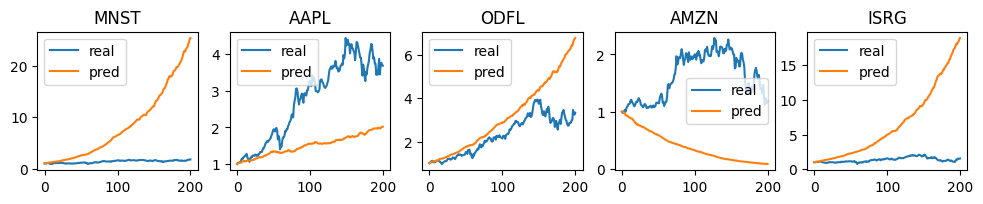

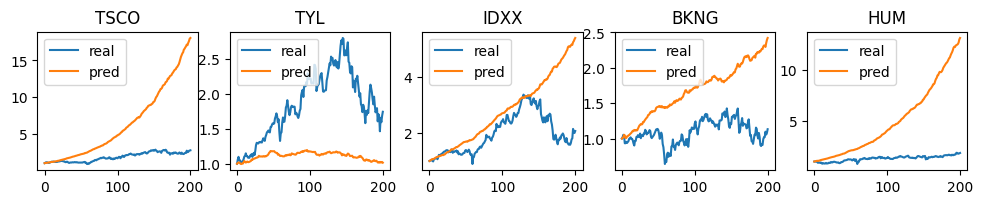

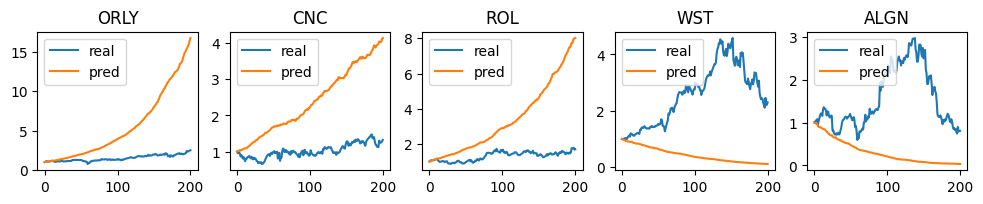

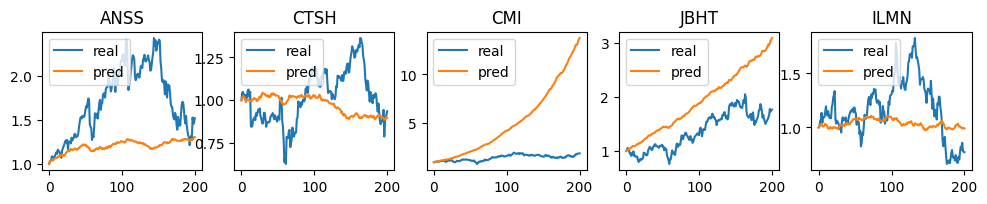

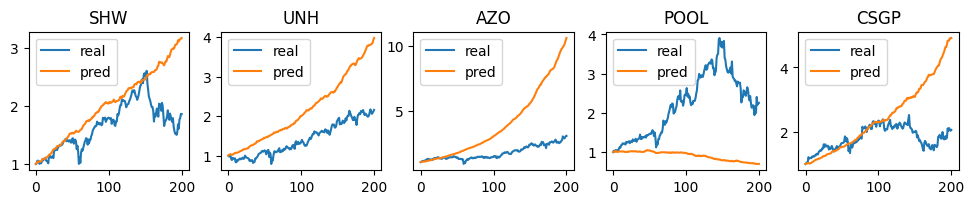

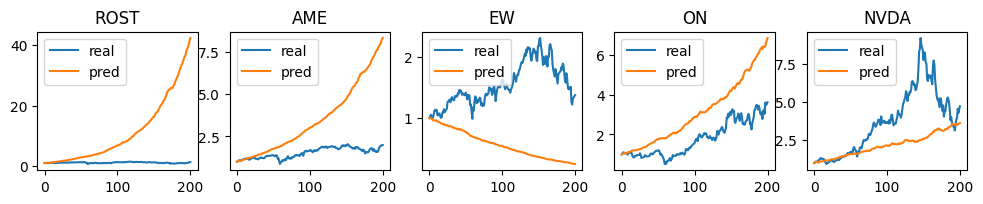

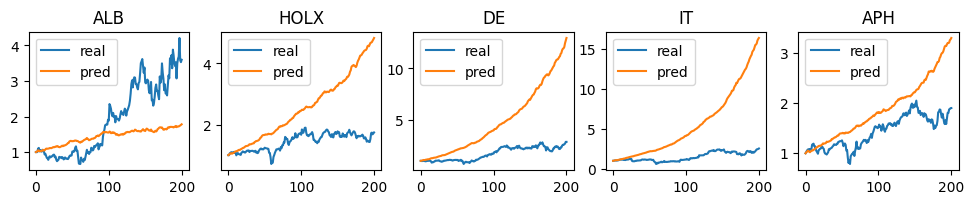

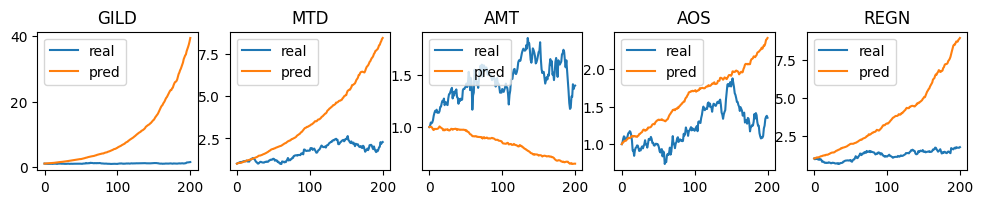

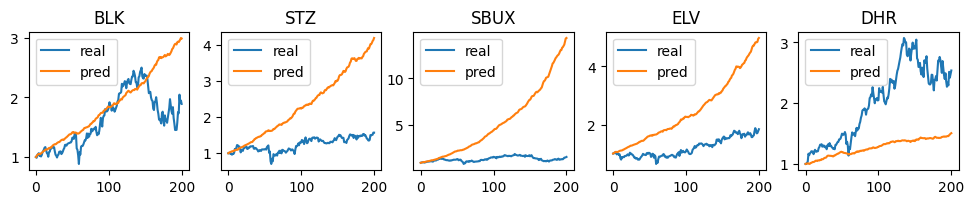

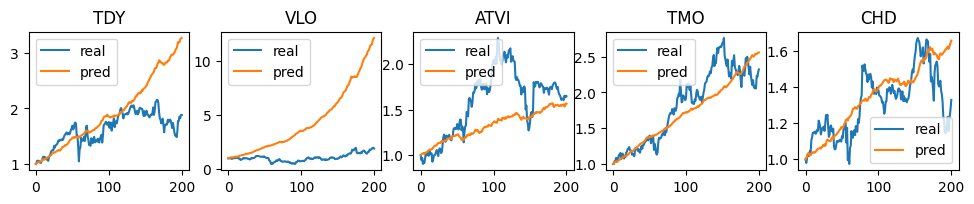

In [8]:
# F, B로 추정한 주가와 실제 주가 차트를 비교한다.
sym2idx = {k:v for v, k in enumerate(list(rtn_df.columns))}
idx2sym = {v:k for k, v in sym2idx.items()}

rtn_EFB = E + np.dot(F, B)  # 추정된 수익률
def calc_price(r):
    prc = [1.0]
    for i in r:
        prc.append(prc[-1] * np.exp(i))
    return prc

# 10행 5열의 plot chart를 그린다.
n_from = -200   # 최근 200 weeks (약 4년)의 주가 차트
for i in np.arange(0, N_COL, 5):
    fig = plt.figure(figsize=(12, 1.8))
    for j in np.arange(i, i+5):
        # 추정 주가와 실제 주가를 계산한다.
        pred_price = calc_price(rtn_EFB[:, j][n_from:])
        real_price = calc_price(rtn_R[:, j][n_from:])
        ax = fig.add_subplot(1, 5, j % 5 + 1)
        ax.plot(real_price, label='real')
        ax.plot(pred_price, label='pred')
        ax.legend()
        ax.set_title(idx2sym[j])
    plt.show() 